# Using and Evaluating the Pretrained CNN
July 31st, 2024

*Chen, S., Thielk, M., & Gentner, T. Q. (2024). Auditory Feature-based Perceptual Distance. bioRxiv, 2024.02.28.582631. https://doi.org/10.1101/2024.02.28.582631*

### Overview of Auditory Feature-based Perceptual Distance (APD):
1. Convert audio files to species-specific frequency scaled spectrogram 
2. Pre-train convolutional neural network (CNN) to learn spectrogram features **(You are here!)**
    - Import Spectrograms
    - Define CNN Inputs/Outputs
    - Define Training/Test Split
    - Define CNN Architecture
    - Fit the Model to the Data
    
    2.1. Evaluating and Using Pretrained CNN **(You are here!)**
    
    

3. Fine-tune CNN with behavioral data

## Using the Pretrained CNN
The point of training the CNN is to have access to a spectrogram comparison method that is robust against temporal and spectral shifting, which are the biggest failures of using MSE. Here we will demonstrate: 
1. How to access the feature embeddings of a spectrogram
2. How to compute auditory perceptual distances (APD) between feature embeddings
3. Test temporal and spectral shifting of APD against MSE. 

## Import Spectrograms
These are the spectrograms from 0_ConvertStarScale.ipynb

In [1]:
import pandas as pd
import os
from apd.utils.paths import DATA_DIR, MODEL_DIR

In [2]:
spec_p = os.path.join(DATA_DIR, 'interim', 'stable_length', 'spec.p')
print(spec_p)

/mnt/cube/j8xing/kai_apd/data/interim/stable_length/spec.p


In [3]:
spec_p = pd.read_pickle(spec_p)

In [4]:
spec_p.head()

,seg,bID,spec
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.57923824, -0.6018052, -0.67933035, -0.884..."
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.5489464, -0.5801697, -0.69067365, -0.7412..."
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.73662823, -0.6833033, -0.6459592, -0.7130..."
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.39315906, -0.41919217, -0.48941904, -0.62..."
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B338,"[[-0.5605774, -0.58246267, -0.6526525, -0.8680..."


In [5]:
spec_h, spec_w = spec_p.spec[0].shape
print(spec_h, spec_w)

291 674


## Load in the CNN

In [6]:
import tensorflow as tf

2024-08-02 10:48:42.128374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 10:48:42.128442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 10:48:42.128486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.backend import clear_session

In [8]:
clear_session()

In [9]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [10]:
try:
    tf.config.experimental.set_memory_growth(gpus[2], True) ## set to use memory dynamically
    tf.config.set_visible_devices([gpus[2]], 'GPU') ## only use gpu2
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 1 Logical GPU


2024-08-02 10:48:46.548741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11471 MB memory:  -> device: 2, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:85:00.0, compute capability: 5.2


### Instantiate model

In [11]:
from tensorflow.keras.applications import VGG19

In [12]:
VGG19_INPUT_SHAPE = (224, 224, 3)

In [13]:
model = VGG19(
    include_top = False,
    weights = None,
    input_shape = VGG19_INPUT_SHAPE,
    pooling = 'avg'
)

### Prepare model input and connect layers

For evaluation, we no longer need to provide spectrogram slices. Here we will have just a single input layer that will feed into our trained VGG19. 

In [14]:
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
model_inputs = Input(shape = (spec_h, spec_w // 3, 3))

In [15]:
model_inputs

<KerasTensor: shape=(None, 291, 224, 3) dtype=float32 (created by layer 'input_2')>

#### Connect Layers

In [16]:
## resize the input to 224, 224, 3 to fit VGG19
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)

## Connect resized layers to VGG19
model_outputs = model(resized)

## The final model is defined as the chain from input (spectrograms) to output (VGG19 embeddings)
feature_extractor = Model(model_inputs, model_outputs)

In [17]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 291, 224, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 20024384 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Load in pretrained weights

In [18]:
#pretrain_folder = os.path.join(MODEL_DIR, 'pretrain', '2024_07_30_14_21_51')
#pretrain_folder = os.path.join(MODEL_DIR, 'pretrain', '2024_08_01_16_28_12')
#weights_file = os.path.join(pretrain_folder, 'weights-improvement.h5')
weights_file = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')
feature_extractor.load_weights(weights_file, by_name=True)

## Extracting Feature Embedding

Let's extract example feature embeddings of 10 random spectrograms. Because we have to slice into 3, we will have 30 spectrograms to play with. 

### Get Example Spectrograms

In [19]:
example_specs = spec_p.sample(n = 10, random_state = 0)
example_specs

,seg,bID,spec
2849,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5571847, -0.5572279, -0.5618122, -0.58281..."
1235,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1145,"[[-0.4581223, -0.34685373, -0.30576712, -0.309..."
2883,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.49790803, -0.5126217, -0.55698997, -0.642..."
4764,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1076,"[[-0.3203432, -0.3084012, -0.30543086, -0.3430..."
521,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1077,"[[-0.60207355, -0.55977446, -0.5341963, -0.542..."
5717,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1053,"[[-0.27087563, -0.26353684, -0.2434009, -0.229..."
5798,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1053,"[[-0.38040996, -0.3505481, -0.3588567, -0.4646..."
3861,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B336,"[[-0.5586621, -0.57108194, -0.62493813, -0.736..."
5052,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B337,"[[-0.73623073, -0.61952436, -0.58027065, -0.58..."
1732,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,B335,"[[-0.4758067, -0.50912356, -0.5866934, -0.6544..."


### Slice spectrograms into input size

In [20]:
import apd.utils.trainingfuncs
import numpy as np
from tqdm import tqdm

In [21]:
INPUT_SHAPE = (spec_h, spec_w // 3)

In [22]:
## prep dataframe
spec_slices = {
    'seg': [],
    'bID': [],
    'd2_spec': [],
    'd3_spec': []
}

## slice and propagate into empty dict
for _, row in tqdm(example_specs.iterrows()):
    for i in range(3):
        spec_slices['seg'].append(row.seg)
        spec_slices['bID'].append(row.bID)
        
        s = row.spec[:, i*INPUT_SHAPE[1]: (i+1)*INPUT_SHAPE[1]]
        spec_slices['d2_spec'].append(s)
        
        s = np.stack([s, s, s], axis = 2)
        spec_slices['d3_spec'].append(s)
        
## exchange dict list to dataframe
spec_slices = pd.DataFrame(spec_slices)

10it [00:00, 607.62it/s]


In [23]:
spec_slices.head()

,seg,bID,d2_spec,d3_spec
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5571847, -0.5572279, -0.5618122, -0.58281...","[[[-0.5571847, -0.5571847, -0.5571847], [-0.55..."
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5529941, -0.5681527, -0.60039586, -0.6428...","[[[-0.5529941, -0.5529941, -0.5529941], [-0.56..."
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5365195, -0.54046786, -0.56937516, -0.635...","[[[-0.5365195, -0.5365195, -0.5365195], [-0.54..."
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1145,"[[-0.4581223, -0.34685373, -0.30576712, -0.309...","[[[-0.4581223, -0.4581223, -0.4581223], [-0.34..."
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1145,"[[-0.37030798, -0.34724492, -0.34995088, -0.39...","[[[-0.37030798, -0.37030798, -0.37030798], [-0..."


## Output embeddings for each sliced spectrogram

In [24]:
vgg19emb = feature_extractor.predict(np.stack(spec_slices.d3_spec.values, axis = 0))

2024-08-02 10:49:05.917287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-08-02 10:49:06.661671: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 5s 5s/step


In [25]:
vgg19emb

array([[0.13775246, 0.09859936, 0.00391822, ..., 0.03481289, 0.0075757 ,
        0.01183685],
       [0.12948276, 0.09527267, 0.00434661, ..., 0.0313841 , 0.00631834,
        0.01539706],
       [0.13046919, 0.09513004, 0.0038598 , ..., 0.03329458, 0.0076909 ,
        0.01355336],
       ...,
       [0.12373725, 0.08976746, 0.00107887, ..., 0.03293191, 0.00734648,
        0.01027869],
       [0.1353114 , 0.09344952, 0.00116652, ..., 0.03880984, 0.00735805,
        0.00644225],
       [0.13234954, 0.09164299, 0.000622  , ..., 0.03873752, 0.00693644,
        0.00521938]], dtype=float32)

In [26]:
spec_slices['vgg19emb'] = list(vgg19emb)

In [27]:
spec_slices.head()

,seg,bID,d2_spec,d3_spec,vgg19emb
0,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5571847, -0.5572279, -0.5618122, -0.58281...","[[[-0.5571847, -0.5571847, -0.5571847], [-0.55...","[0.13775246, 0.09859936, 0.003918219, 0.000102..."
1,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5529941, -0.5681527, -0.60039586, -0.6428...","[[[-0.5529941, -0.5529941, -0.5529941], [-0.56...","[0.12948276, 0.09527267, 0.0043466114, 0.00038..."
2,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1160,"[[-0.5365195, -0.54046786, -0.56937516, -0.635...","[[[-0.5365195, -0.5365195, -0.5365195], [-0.54...","[0.13046919, 0.09513004, 0.0038598008, 0.00012..."
3,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1145,"[[-0.4581223, -0.34685373, -0.30576712, -0.309...","[[[-0.4581223, -0.4581223, -0.4581223], [-0.34...","[0.12091455, 0.089840546, 0.005281682, 9.21826..."
4,/mnt/cube/j8xing/kai_apd/data/interim/stable_l...,b1145,"[[-0.37030798, -0.34724492, -0.34995088, -0.39...","[[[-0.37030798, -0.37030798, -0.37030798], [-0...","[0.122263856, 0.09184668, 0.004634777, 0.00012..."


## Calculate APD between embeddings
Now that we have vgg19 embeddings, we can calculate RMSE between embeddings to form auditory perceptual distance (APD). Let's pull out the first two spectrograms and calculate the RMSE between them. 

In [28]:
spec_two = spec_slices[0:2]

### Plot the two spectrograms

In [29]:
import matplotlib.pyplot as plt
import librosa

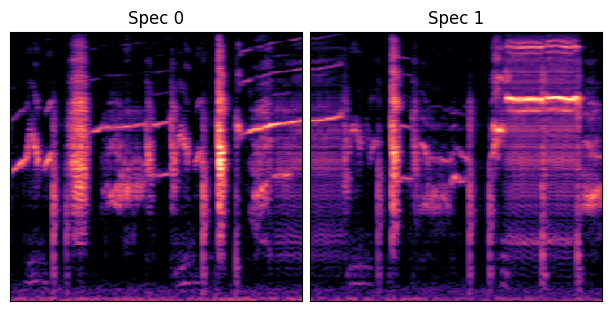

In [30]:
fig, axes = plt.subplots(figsize = (6, 3), ncols = 2, sharex = True, constrained_layout = True)

for i in range(len(spec_two)):
    s = spec_two.d2_spec.values[i]
    img = librosa.display.specshow(
        s,
        hop_length = 256,
        sr = 44100,
        ax = axes[i]
    )
    axes[i].set_title(f'Spec {i}')

### Calculate APD
APD is the cosine distance between vgg19 features. 

In [31]:
from scipy.spatial import distance
from apd.utils.math_utils import rmse

In [32]:
feats = {}

for i in range(len(spec_two)):
    feats[i] = spec_two.vgg19emb.values[i]

In [33]:
feat_d01 = distance.cosine(feats[0], feats[1])/2

In [34]:
print(f'APD: {feat_d01}')

APD: 0.00045235608848170905


## Test temporal and spectral shifting of APD against MSE

### Spectral shifting

We will add n frames of empty space to spectrograms to the top and to the bottom. We will do this for each spectrogram 15 times, resulting in 1-15 frames shifted spectrograms.

Once we have 15 pairs of tops and bottoms, we will compute the normalized cosine distance (0-1) between their feature vectors. We will also compute the spectrogram RMSE between each pair for referece. 

In [35]:
spec_shift = {
    'spec': [],
    'n_slices': [],
    'feat_cos': [],
    'spec_rmse': []
}

## For every spec slice
for i, row in tqdm(spec_slices.iterrows(), desc = 'Processing each spectrogram'):
    s = row.d2_spec
    
    for n_slices in range(15): ## we are shifting 15 times
        blank_frames = np.full((n_slices + 1, s.shape[1]), -1, dtype = float)
        
        ## add blank frames to top or bottom of the specs
        top_spec = np.vstack((blank_frames, s))
        bottom_spec = np.vstack((s, blank_frames))
        
        ## stack into a 3d image
        top_3d = np.stack([top_spec, top_spec, top_spec], axis = 2)
        bottom_3d = np.stack([bottom_spec, bottom_spec, bottom_spec], axis = 2)
        
        ## compute embeddings/feature vector
        top_features = np.squeeze(feature_extractor.predict(np.expand_dims(top_3d, axis=0), verbose = 0))
        bottom_features = np.squeeze(feature_extractor.predict(np.expand_dims(bottom_3d, axis=0), verbose = 0))
        
        ## import into prepped dataframe
        spec_shift['spec'].append(i)
        spec_shift['n_slices'].append(n_slices)
        spec_shift['feat_cos'].append(distance.cosine(top_features, bottom_features) / 2)
        spec_shift['spec_rmse'].append(rmse(top_3d, bottom_3d))

spec_shift = pd.DataFrame(spec_shift)

Processing each spectrogram: 30it [01:11,  2.38s/it]


In [36]:
spec_shift

,spec,n_slices,feat_cos,spec_rmse
0,0,0,0.002225,0.052690
1,0,1,0.007256,0.078403
2,0,2,0.016496,0.093185
3,0,3,0.016259,0.102198
4,0,4,0.018602,0.107545
...,...,...,...,...
445,29,10,0.014286,0.149454
446,29,11,0.023402,0.153176
447,29,12,0.024398,0.156118
448,29,13,0.033115,0.158475


In [37]:
## process into graphable form
spec_shift_plot_df = pd.melt(
    spec_shift,
    id_vars = ['spec', 'n_slices'],
    value_vars = ['feat_cos', 'spec_rmse'],
    var_name = 'metric'
)

### Plot Example Shifted Spectrogram

Text(0.5, 1.0, 'Bottom shifted')

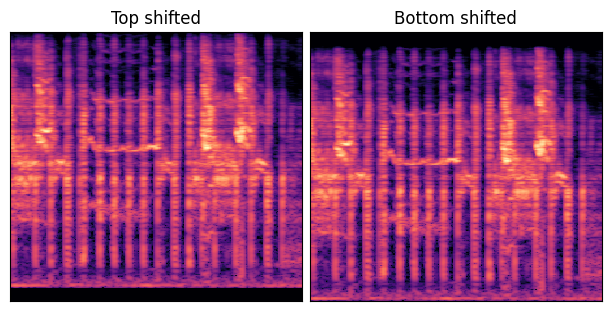

In [38]:
fig, axes = plt.subplots(figsize = (6, 3), ncols = 2, sharex = True, constrained_layout = True)

img = librosa.display.specshow(
    top_spec,
    hop_length = 256,
    sr = 44100,
    ax = axes[0]
)

axes[0].set_title(f'Top shifted')

img = librosa.display.specshow(
    bottom_spec,
    hop_length = 256,
    sr = 44100,
    ax = axes[1]
)

axes[1].set_title(f'Bottom shifted')

### Plot Metric Differences

In [39]:
import seaborn as sns

Text(0.5, 1.0, 'Shifting in frequency domain')

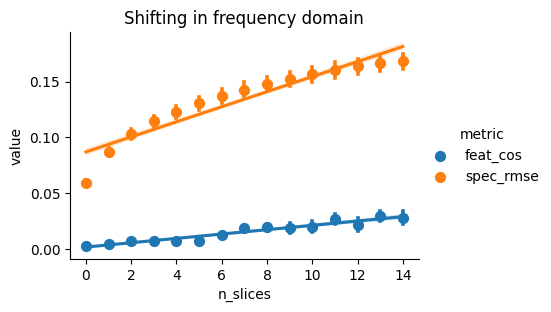

In [40]:
g = sns.lmplot(
    x='n_slices', 
    y='value', 
    data=spec_shift_plot_df, 
    hue='metric', 
    x_estimator=np.mean,
    height=3, aspect=1.5,
    legend=True
)
plt.title('Shifting in frequency domain')

Text(0.5, 1.0, 'Shifting in frequency domain')

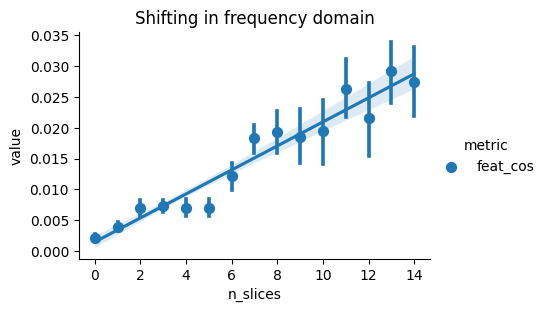

In [41]:
g = sns.lmplot(
    x='n_slices', 
    y='value', 
    data=spec_shift_plot_df[spec_shift_plot_df.metric == 'feat_cos'], 
    hue='metric', 
    x_estimator=np.mean,
    height=3, aspect=1.5,
    legend=True
)
plt.title('Shifting in frequency domain')

### Temporal shifting

We will add n frames of empty space to spectrograms to the left and to the right. We will do this for each spectrogram 15 times, resulting in 1-15 frames shifted spectrograms.

Once we have 15 pairs of lefts and rights, we will compute the normalized cosine distance (0-1) between their feature vectors. We will also compute the spectrogram RMSE between each pair for referece. 

In [42]:
temp_shift = {
    'spec': [],
    'n_slices': [],
    'feat_cos': [],
    'spec_rmse': []
}

## For every spec slice
for i, row in tqdm(spec_slices.iterrows(), desc = 'Processing each spectrogram'):
    s = row.d2_spec
    
    for n_slices in range(15): ## we are shifting 15 times
        blank_frames = np.full((s.shape[0], n_slices + 1), -1, dtype = float)
        
        ## add blank frames to left or right of the specs
        left_spec = np.hstack((blank_frames, s))
        right_spec = np.hstack((s, blank_frames))
        
        ## stack into a 3d image
        left_3d = np.stack([left_spec, left_spec, left_spec], axis = 2)
        right_3d = np.stack([right_spec, right_spec, right_spec], axis = 2)
        
        ## compute embeddings/feature vector
        left_features = np.squeeze(feature_extractor.predict(np.expand_dims(left_3d, axis=0), verbose = 0))
        right_features = np.squeeze(feature_extractor.predict(np.expand_dims(right_3d, axis=0), verbose = 0))
        
        ## import into prepped dataframe
        temp_shift['spec'].append(i)
        temp_shift['n_slices'].append(n_slices)
        temp_shift['feat_cos'].append(distance.cosine(left_features, right_features) / 2)
        temp_shift['spec_rmse'].append(rmse(left_3d, right_3d))

temp_shift = pd.DataFrame(temp_shift)

Processing each spectrogram: 30it [01:13,  2.44s/it]


In [43]:
temp_shift

,spec,n_slices,feat_cos,spec_rmse
0,0,0,0.000011,0.050573
1,0,1,0.000030,0.088932
2,0,2,0.000018,0.119664
3,0,3,0.000108,0.143867
4,0,4,0.000353,0.162307
...,...,...,...,...
445,29,10,0.000161,0.195514
446,29,11,0.000069,0.198709
447,29,12,0.000070,0.209988
448,29,13,0.000391,0.225320


In [44]:
## process into graphable form
temp_shift_plot_df = pd.melt(
    temp_shift,
    id_vars = ['spec', 'n_slices'],
    value_vars = ['feat_cos', 'spec_rmse'],
    var_name = 'metric'
)

### Plot Example Shifted Spectrogram

Text(0.5, 1.0, 'Right shifted')

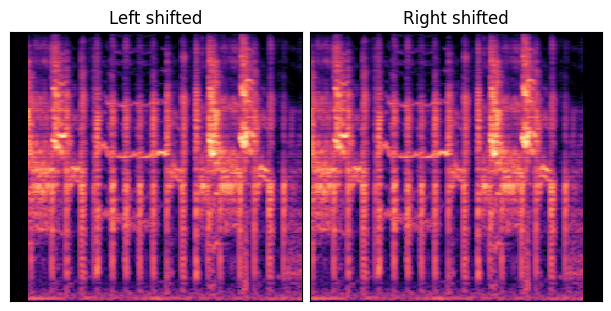

In [45]:
fig, axes = plt.subplots(figsize = (6, 3), ncols = 2, sharex = True, constrained_layout = True)

img = librosa.display.specshow(
    left_spec,
    hop_length = 256,
    sr = 44100,
    ax = axes[0]
)

axes[0].set_title(f'Left shifted')

img = librosa.display.specshow(
    right_spec,
    hop_length = 256,
    sr = 44100,
    ax = axes[1]
)

axes[1].set_title(f'Right shifted')

### Plot Metric Differences

In [46]:
import seaborn as sns

Text(0.5, 1.0, 'Shifting in temp domain')

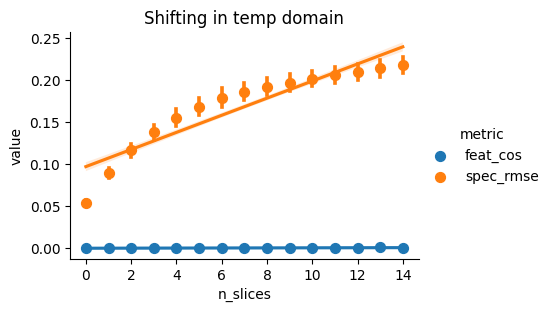

In [47]:
g = sns.lmplot(
    x='n_slices', 
    y='value', 
    data=temp_shift_plot_df, 
    hue='metric', 
    x_estimator=np.mean,
    height=3, aspect=1.5,
    legend=True
)
plt.title('Shifting in temp domain')

Text(0.5, 1.0, 'Shifting in frequency domain (APD only)')

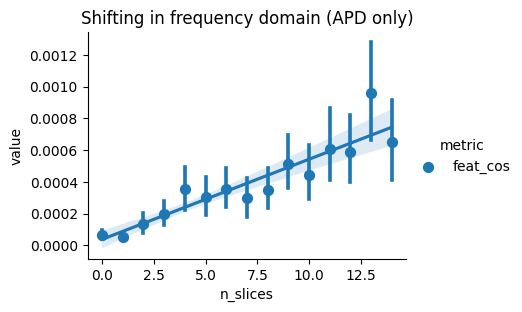

In [48]:
g = sns.lmplot(
    x='n_slices', 
    y='value', 
    data=temp_shift_plot_df[temp_shift_plot_df.metric == 'feat_cos'], 
    hue='metric', 
    x_estimator=np.mean,
    height=3, aspect=1.5,
    legend=True
)
plt.title('Shifting in frequency domain (APD only)')